# Matrix Factorisation with Cosine Similarity

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import torch
from tdc.multi_pred import DTI
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import logging
from rdkit import Chem

# load in the three datasets
data_Kd = DTI(name = 'BindingDB_Kd')
data_Kd.convert_to_log(form = 'binding')

data_ic50 = DTI(name = 'BindingDB_IC50')
data_ic50.convert_to_log(form = 'binding')

data_Ki = DTI(name = 'BindingDB_Ki')
data_Ki.convert_to_log(form = 'binding')

Found local copy...
Loading...
Done!
To log space...
Found local copy...
Loading...
Done!
To log space...
Found local copy...
Loading...
Done!
To log space...


## Data processing
Model used is adapted from https://medium.com/@rinabuoy13/explicit-recommender-system-matrix-factorization-in-pytorch-f3779bb55d74

In [2]:
def data_split(data):
    # split data and get ID dicts
    split = data.get_split(method = 'random', seed = 42, frac = [0.6, 0.05, 0.35])
    train = split['train']
    test = split['test']

    train = train[['Drug_ID', 'Drug', 'Target', 'Y']].dropna()
    train = train.reset_index(drop=True)


    ID_to_Drug = dict(enumerate(list(dict.fromkeys(train['Drug_ID']))))
    ID_to_Target = dict(enumerate(list(dict.fromkeys(train['Target']))))

    Drug_to_ID = dict((v,k) for k,v in ID_to_Drug.items())
    Target_to_ID = dict((v,k) for k,v in ID_to_Target.items())
    train['Drug_ID'][6]
    return train, test, Drug_to_ID, Target_to_ID

def data_loader(data, drug_dict, target_dict):
    # load data into correct format
    data["Target_ID2"] = data["Target"].apply(lambda x:target_dict.get(x))
    data["Drug_ID2"] = data["Drug_ID"].apply(lambda x:drug_dict.get(x))
    data = data.dropna()

    drug_ID = data["Drug_ID2"].to_numpy()
    target_ID = data["Target_ID2"].to_numpy()
    features = np.vstack((drug_ID, target_ID)).T
    label = data['Y'].to_numpy()
    return features, label

class RatingDataset(Dataset):
    def __init__(self, train, label):
        self.feature_= train
        self.label_= label
    def __len__(self):
    #return size of dataset
        return len(self.feature_)
    def __getitem__(self, idx):
        return  torch.tensor(self.feature_[idx], dtype=torch.long),torch.tensor(self.label_[idx], dtype=torch.float)
    
    
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        
        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items,1)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)
        
        # NEW WEIGHTS FOR THE SIMILARITY MATRIX
        self.user_sim = torch.nn.Embedding(n_users, 1)
        self.item_sim = torch.nn.Embedding(n_items, 1)
        torch.nn.init.xavier_uniform_(self.user_sim.weight)
        torch.nn.init.xavier_uniform_(self.item_sim.weight)

        
    def forward(self, user, item, sim_user, sim_item):
        user_len = len(user)
        item_len = len(item)
        
        AAT_list = [torch.dot(self.user_factors(user)[i,:], self.user_factors(user)[i,:]) for i in range(self.user_factors(user).shape[0])]
        AAT = torch.tensor(AAT_list)
        
        BBT_list = [torch.dot(self.item_factors(item)[i,:], self.item_factors(item)[i,:]) for i in range(self.item_factors(item).shape[0])]
        BBT = torch.tensor(BBT_list)
        
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        
        # Sd = A*AT
        pred += ((sim_user[user][:,0] * self.user_sim(user).double().reshape(user_len)) - AAT).reshape(user_len,1)
        # St = B*BT
        pred += ((sim_item[item][:,0] * self.item_sim(item).double().reshape(item_len)) - BBT).reshape(item_len,1)
        
        return pred.squeeze()

## Creating Similarity Matrix for drugs and target
Idea behind this is using vector representation of either the drug or target and then using sklearns cosine similarity function on it.

Below function taken from pykale library: https://github.com/pykale/pykale/blob/3d99c061b7cd014fa1bc0f2bc83c9da343ab5524/kale/prepdata/chem_transform.py#L188

In [3]:
CHARPROTSET = {
    "A": 1,
    "C": 2,
    "B": 3,
    "E": 4,
    "D": 5,
    "G": 6,
    "F": 7,
    "I": 8,
    "H": 9,
    "K": 10,
    "M": 11,
    "L": 12,
    "O": 13,
    "N": 14,
    "Q": 15,
    "P": 16,
    "S": 17,
    "R": 18,
    "U": 19,
    "T": 20,
    "W": 21,
    "V": 22,
    "Y": 23,
    "X": 24,
    "Z": 25,
}

CHARPROTLEN = 25

CHARISOSMISET = {
    "#": 29,
    "%": 30,
    ")": 31,
    "(": 1,
    "+": 32,
    "-": 33,
    "/": 34,
    ".": 2,
    "1": 35,
    "0": 3,
    "3": 36,
    "2": 4,
    "5": 37,
    "4": 5,
    "7": 38,
    "6": 6,
    "9": 39,
    "8": 7,
    "=": 40,
    "A": 41,
    "@": 8,
    "C": 42,
    "B": 9,
    "E": 43,
    "D": 10,
    "G": 44,
    "F": 11,
    "I": 45,
    "H": 12,
    "K": 46,
    "M": 47,
    "L": 13,
    "O": 48,
    "N": 14,
    "P": 15,
    "S": 49,
    "R": 16,
    "U": 50,
    "T": 17,
    "W": 51,
    "V": 18,
    "Y": 52,
    "[": 53,
    "Z": 19,
    "]": 54,
    "\\": 20,
    "a": 55,
    "c": 56,
    "b": 21,
    "e": 57,
    "d": 22,
    "g": 58,
    "f": 23,
    "i": 59,
    "h": 24,
    "m": 60,
    "l": 25,
    "o": 61,
    "n": 26,
    "s": 62,
    "r": 27,
    "u": 63,
    "t": 28,
    "y": 64,
}

CHARISOSMILEN = 64

CHARATOMSET = [
    "C",
    "N",
    "O",
    "S",
    "F",
    "Si",
    "P",
    "Cl",
    "Br",
    "Mg",
    "Na",
    "Ca",
    "Fe",
    "As",
    "Al",
    "I",
    "B",
    "V",
    "K",
    "Tl",
    "Yb",
    "Sb",
    "Sn",
    "Ag",
    "Pd",
    "Co",
    "Se",
    "Ti",
    "Zn",
    "H",
    "Li",
    "Ge",
    "Cu",
    "Au",
    "Ni",
    "Cd",
    "In",
    "Mn",
    "Zr",
    "Cr",
    "Pt",
    "Hg",
    "Pb",
    "Unknown",
]

CHARATOMLEN = 44


def integer_label_smiles(smiles, max_length=85, isomeric=False):
    """
    Integer encoding for SMILES string sequence.
    Args:
        smiles (str): Simplified molecular-input line-entry system, which is a specification in the form of a line
        notation for describing the structure of chemical species using short ASCII strings.
        max_length (int): Maximum encoding length of input SMILES string. (default: 85)
        isomeric (bool): Whether the input SMILES string includes isomeric information (default: False).
    """
    if not isomeric:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            logging.warning(f"rdkit cannot find this SMILES {smiles}.")
            return None
        smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True)
    encoding = np.zeros(max_length)
    for idx, letter in enumerate(smiles[:max_length]):
        try:
            encoding[idx] = CHARISOSMISET[letter]
        except KeyError:
            logging.warning(
                f"character {letter} does not exists in default SMILE category encoding, skip and treat as " f"padding."
            )

    return encoding


def integer_label_protein(sequence, max_length=1200):
    """
    Integer encoding for protein string sequence.
    Args:
        sequence (str): Protein string sequence.
        max_length: Maximum encoding length of input protein string. (default: 1200)
    """
    encoding = np.zeros(max_length)
    for idx, letter in enumerate(sequence[:max_length]):
        try:
            encoding[idx] = CHARPROTSET[letter]
        except KeyError:
            logging.warning(
                f"character {letter} does not exists in sequence category encoding, skip and treat as " f"padding."
            )
    return encoding

In [4]:
def cos_matrix(data, col, Drug):
    # creates cosine matrix using sklearn function
    sentences = []
    sentences_comb = []
    for i in range(len(data[col])):
        if Drug == True:
            num_rep = integer_label_smiles(data[col][i])
            num_rep_trim = np.trim_zeros(num_rep).astype(str)
        else:
            num_rep = integer_label_protein(data[col][i])
            num_rep_trim = np.trim_zeros(num_rep).astype(str)

        sentences.append(num_rep_trim)

        str_rep = " ".join(num_rep_trim)
        sentences_comb.append(str_rep)
    vectorizer = CountVectorizer().fit_transform(sentences_comb)
    vectors = vectorizer.toarray()
    csim = cosine_similarity(vectors)
    return csim

In [5]:
def train_model(train_loader, test_loader, model, csim_drug, csim_target, num_epochs=100):
#     dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # need to change dtype to float to reduce resources required
    dev = torch.device("cpu")
    loss_func = torch.nn.MSELoss()
    model.to(dev)
    
    train_losses = []
    test_losses = []
    for epoch in range(0,num_epochs):
        count = 0
        cum_loss = 0.
        for i, (train_batch, label_batch) in enumerate(train_loader):
            count = 1 + i
            # Predict and calculate loss for user factor and bias
            #### WEIGHTS FOR USER SIMILARITY MATRIX ADDED INTO OPTIMISER HERE
            optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight,
                                         model.user_sim.weight], lr=0.01, weight_decay=1e-5)
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev), csim_drug.to(dev), csim_target.to(dev))
            loss = loss_func(prediction, label_batch.to(dev)).float()    
            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()

            # predict and calculate loss for item factor and bias
            #### WEIGHTS FOR ITEM SIMILARITY MATRIX ADDED INTO OPTIMISER HERE
            optimizer = torch.optim.SGD([model.item_biases.weight,model.item_factors.weight,
                                    model.item_sim.weight], lr=0.01, weight_decay=1e-5)             
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev), csim_drug.to(dev), csim_target.to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            loss_item = loss.item()
            cum_loss += loss_item


            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()
        train_loss = cum_loss/count
        train_losses.append(train_loss)

        cum_loss =0.
        count = 0
        for i, (test_batch, label_batch) in enumerate(test_loader):
            count = 1 + i
            with torch.no_grad():
                prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev), csim_drug.to(dev), csim_target.to(dev))
                loss = loss_func(prediction, label_batch.to(dev))
                cum_loss += loss.item()

        test_loss = cum_loss/count
        test_losses.append(test_loss)
        if epoch % 1 == 0:
            print('epoch: ', epoch ,' avg training loss: ', train_loss, ' avg test loss: ',test_loss)
    return train_losses, test_losses

In [6]:
def model(data, img_name, n_factors=100, bs=100, num_epochs=100):
    train, test, drug_dict, target_dict = data_split(data)
    x_train, y_train = data_loader(train, drug_dict, target_dict)
    x_test, y_test = data_loader(test, drug_dict, target_dict)

    train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)
    
    train, test, drug_dict, target_dict = data_split(data_Kd)

    # cosine similarity matrix drug
    csim_drug_np = cos_matrix(train, 'Drug', True)

    # cosine similarity matrix target
    csim_target_np = cos_matrix(train, 'Target', False)

    model = MatrixFactorization(len(drug_dict), len(target_dict), n_factors=n_factors)
    
    csim_drug = torch.from_numpy(csim_drug_np)
    csim_target = torch.from_numpy(csim_target_np)

    train_losses, test_losses = train_model(train_dataloader, test_dataloader, model, csim_drug, csim_target, num_epochs)

    epochs = range(1, num_epochs+1)
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, test_losses, label='test')
    plt.xlabel('epoch')
    plt.ylabel('mse loss')
    plt.legend()
    plt.title(img_name)
#     plt.savefig(img_name)
    plt.show()

epoch:  0  avg training loss:  32.378538508324105  avg test loss:  25.24917823246547
epoch:  1  avg training loss:  24.78769471235336  avg test loss:  18.609627655574254
epoch:  2  avg training loss:  19.889336771266475  avg test loss:  14.378443997246878
epoch:  3  avg training loss:  16.61600741307447  avg test loss:  11.599643863950456
epoch:  4  avg training loss:  14.369577070710006  avg test loss:  9.7171352658953
epoch:  5  avg training loss:  12.758968274304822  avg test loss:  8.401865223475864
epoch:  6  avg training loss:  11.573910843794513  avg test loss:  7.455543518066406
epoch:  7  avg training loss:  10.671156899944233  avg test loss:  6.755010497570038
epoch:  8  avg training loss:  9.961823644152112  avg test loss:  6.221699133941105
epoch:  9  avg training loss:  9.386900226022028  avg test loss:  5.804910121645246


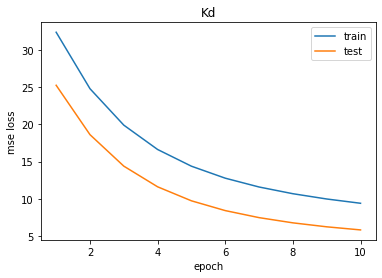

In [7]:
model(data_Kd, 'Kd', n_factors=50, bs=100, num_epochs=10)

## DO NOT RUN PAST HERE
Data is too large to use the previous method

In [ ]:
# model(data_ic50, 'ic50', n_factors=50, bs=100, num_epochs=10)

In [ ]:
# model(data_Ki, 'Ki', n_factors=50, bs=100, num_epochs=10)